# INITIAL WHATEVER

In [12]:
import math
import numpy
import numpy.random
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import norm
from pt.plotter import *

set_default_plotter_options({
    'num_anomalies': [1, 2, 3, 4, 5],
    'transaction_events': [
        numpy.floor(10**x) for x in 
        [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5]
    ],
})

### Generate Data with Anomalies

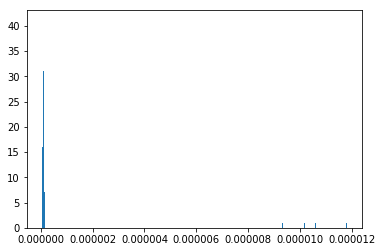

In [3]:
%matplotlib inline
rand = numpy.random.RandomState(seed=1234567)

def gen_data(events, *times):
    x = rand.normal(times[0], times[0]/5, events)
    
    d = 0
    for i in range(1, len(times)):
        t = times[i]
        num_anomalous_events = int(rand.normal(5, 1))
        for e in rand.normal(t, t/5, num_anomalous_events):
            x[d] = e
            d += 1

    rand.shuffle(x)
    return x

x = gen_data(100, 1e-7, 1e-5)
plot_data = matplotlib.pyplot.hist(x, 500)

Variables:
1. Number of points
2. Number of anomalies
3. Number of necessary starting data points
4. Frequency/Distribution of anomalies (e.g. what if a bunch happen close together vs far apart?)
5. Frequency/Distribution of data points in time

Experiment:
- Run algorithm on a set of data N times
- Measure the success of each run according to criteria below
- Aggregate that into a single number we can use to compare algorithms

Analysis Criteria:
- some sort of weighted sum of True Positive, False Positive, True Negative, and False Negative
- some sort of overhead calculation

Equipment Needed:
1. Function to generate data with anomalies in it that looks kind of realistic
    - Scrape durations from existing data
    - Add anomalies into it to form a composite data set
2. Function to calculate success criteria from a given run
3. Some algorithms

### Sanity Check

Check that method makes sense; for constant-size changes to the data over time, differences made when the baseline is smaller should show up more prominently than when the baseline is larger

In [ ]:
%matplotlib inline

p1 = numpy.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
p2 = numpy.array([1, 2, 4, 4, 5, 6, 7, 8, 9, 10])
p3 = numpy.array([1, 2, 3, 4, 5, 6, 8, 8, 9, 10])

matplotlib.pyplot.plot(numpy.cumsum(numpy.abs(numpy.diff(p2/p1))))
matplotlib.pyplot.plot(numpy.cumsum(numpy.abs(numpy.diff(p2)/numpy.diff(p1))))
#matplotlib.pyplot.plot(numpy.cumsum(numpy.abs(numpy.diff(p3/p1))))

## Come up with a way to calculate bin width and kernel width

63
63
7.937253933193772

1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
4
6
9


IQR delta 3.49875746223e-09
mean of deltas 9.29215313882e-09
median of deltas 7.69404377411e-09
sample std 2.69101820146e-08


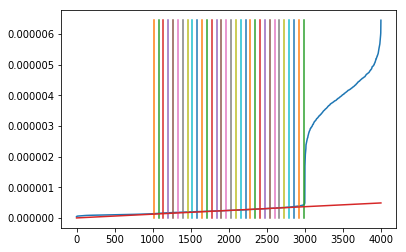

In [185]:
seed_points = 1000

seeds = numpy.array(
        list(gen_data(seed_points, 1e-7))
      + list(gen_data(seed_points, 2e-7))
      + list(gen_data(seed_points, 3e-7))
      + list(gen_data(seed_points, 4e-6)))

ls = len(seeds)

sorted_durations = sorted(seeds)
matplotlib.pyplot.plot(sorted_durations)

lsd = len(sorted_durations)
num_deltas = int(lsd ** 0.5)
points_per_bin = int(len(sorted_durations) / num_deltas)

print(num_deltas)
print(points_per_bin)
print(points_per_bin ** 0.5)

start = int(num_deltas / 4)
finish = int(3 * num_deltas / 4) + 1

mp = sorted_durations[-1]
last_marker = sorted_durations[int(start * lsd / num_deltas)]

deltas = []
for i in range(start+1, finish):
    x = int(lsd * i / num_deltas)
    d = sorted_durations[x]
    
    deltas.append(d - last_marker)
    last_marker = d
    
    matplotlib.pyplot.plot([x, x], [0, mp])
    
sorted_deltas = sorted(deltas)
print()
print("\n".join([str(int(round(x/sorted_deltas[0], 0))) for x in sorted_deltas]))
print()

midpoint = int(len(sorted_deltas) / 2)
if len(sorted_deltas) % 2 == 1:
    median_of_medians = sorted_deltas[midpoint]
else:
    median_of_medians = (sorted_deltas[midpoint - 1] + sorted_deltas[midpoint]) / 2

mean_of_medians = numpy.mean(sorted_deltas)
    
xdata = numpy.array(range(ls))
slope = median_of_medians / points_per_bin
intercept = sorted_durations[int(ls/2)] - slope * xdata[int(ls/2)]
ydata = slope * xdata + intercept
matplotlib.pyplot.plot(ydata)

p25 = sorted_durations[int(lsd * start / num_deltas)]
p75 = sorted_durations[int(lsd * (finish - 1) / num_deltas)]
IQR = (p75 - p25) / 1.349

print()
print("IQR delta", IQR / num_deltas)
print("mean of deltas", mean_of_medians)
print("median of deltas", median_of_medians)
print("sample std", numpy.std(sorted_durations) / num_deltas)


### Kernel Estimation Classes

In [390]:
class Kernel(object):
    def __init__(self, width, offsets=8):
        self.width = width + 1
        self.base_kernel = list(
            norm.pdf(
                numpy.linspace(
                    norm.ppf(0.01),
                    norm.ppf(0.99),
                    width)))
        
        self.offsets = offsets
        self.kernels = []
        
        start = 0.0
        for x in range(offsets):
            end = x/offsets
            self.kernels.append((start, end, self._generate_shift(x/offsets)))
        
    def shift(self, offset):
        low = 0
        high = self.offsets - 1
                                
        while True:
            midpoint = (low + high) // 2
            start = self.kernels[midpoint][0]
            end = self.kernels[midpoint][1]
            if (offset >= start) and (offset < end):
                return self.kernels[midpoint][2]
                                
            elif offset <= end:
                if midpoint == 0:
                    return self.kernels[0][2]
                high = midpoint

            elif offset > start:
                if midpoint == self.offsets - 1:
                    return self.kernels[0][2]
                low = midpoint
            else:
                raise Exception("What?")

    def _generate_shift(self, fractional_offset):
        leftovers = 0
        shifted = []

        for kslice in self.base_kernel:
            shifted_part = fractional_offset * kslice
            shifted.append(leftovers + fractional_offset * kslice)
            leftovers = kslice - shifted_part

        shifted.append(leftovers)
        return shifted

In [515]:
class PrecisionRegion(object):
    def __init__(self, index, precision, start, end, ratio_to_previous, total_ratio):
        self.index = index
        self.precision = precision
        self.start = start
        self.end = end
        self.ratio_to_previous = int(ratio_to_previous)
        self.total_ratio = int(total_ratio)

class PrecisionIndex(object):
    def __init__(self, base_precision, kernel_width):
        self.base_precision = base_precision
        self.kernel_width = kernel_width
        self.hkw = self.kernel_width // 2
        self.regions = []

    def add_region(self, start, end, ratio_to_previous, total_ratio):
        precision = self.base_precision * total_ratio
        pr = PrecisionRegion(len(self.regions), precision, start, end, ratio_to_previous, total_ratio)
        self.regions.append(pr)

    def construct(self, points_per_tile, sorted_durations, deltas):
        self.minimum_allowed = self.base_precision * self.hkw
        
        # first pass: split the deltas into chunks

        chunks = [(0, 1)]
        current_ratio = 1
        primed = True
        for i in range(len(deltas)):
            cp = deltas[i]
            new_ratio = max(1, cp // self.base_precision)
            if primed:
                if (new_ratio > 2*current_ratio) or (2*new_ratio < current_ratio):
                    chunks.append([i, new_ratio])
                    primed = False
            else:
                chunks[-1][-1] = new_ratio
                primed = True
            
            current_ratio = new_ratio
            
        # second pass: calculate regions
        
        regions = []
        ratio_to_previous = 1
        
        for c in range(len(chunks)):
            i, ratio = chunks[c]
            
            if c > 0:
                start = sorted_durations[(i+2) * points_per_tile]
                regions[-1][1] = start
            else:
                start = self.minimum_allowed
            
            aligned_ratio = 2 ** int(math.log2(ratio))
            ratio_to_previous = int(aligned_ratio / ratio_to_previous)
            precision = self.base_precision * aligned_ratio
            
            regions.append([start, end, ratio_to_previous, aligned_ratio])
            start = end
            
        regions[-1][1] = (sorted_durations[points_per_tile * (len(deltas) - 1)]
                          + 1000 * self.base_precision * regions[-1][-1])
            
        # third pass: decrease the ratio of each region so that each region
        #             never overlaps more than one on each side of it
        
        lr = len(regions)
        for r in range(1, lr):
            current = regions[r]
            
            self._reduce_ratio(current, regions[r-1][0], self._reduce_ratio_prev)
            
            if r < lr - 1:
                self._reduce_ratio(current, regions[r+1][0], self._reduce_ratio_next)
             
        # fourth pass: merge any adjacent chunks with the same ratio
        
        current_ratio = None
        for region in regions:
            if region[-1] == current_ratio:
                continue

            self.add_region(*region)
            current_ratio = region[-1]
                    
    def _reduce_ratio(self, region, threshold, calc_edge):
        while True:
            ce = calc_edge(region)
            
            if calc_edge(region) > threshold:
                break

            region[-1] /= 2
            region[-2] /= 2

            if region[-2] <= 1:
                break
                
    def _reduce_ratio_prev(self, region):
        return region[0] - self.base_precision * self.hkw * region[-1]
    
    def _reduce_ratio_next(self, region):
        return region[1] + self.base_precision * self.hkw * region[-1]
    
    def lookup(self, duration):
        if duration <= self.minimum_allowed:
            return self.regions[0]
        if duration <= self.maximum_allowed:
            return self.regions[-1]
        
        last_node = len(self.regions) - 1
        low = 0
        high = last_node
        
        while True:
            midpoint = (low + high) // 2
            node = self.regions[midpoint]
            
            if (duration >= node.start) and (duration < node.end):
                return node.precision
            
            if duration < node.end:
                if midpoint == 0:
                    return self.regions[0]
                high = midpoint
                
            elif duration >= node.start:
                if midpoint == last_node:
                    return self.regions[last_node]
                low = midpoint

            else:
                raise Exception("What?")

In [517]:
a = list(numpy.linspace(1e-6, 1.5e-6, 65))
b = list(numpy.linspace(8e-6, 9e-6, 60))

sd = a + b
lsd = len(sd)

points_per_tile = max(15, int(numpy.sqrt(lsd)))
tile = lsd / points_per_tile
num_tiles = int(tile)

print(points_per_bin, tile, num_tiles)
print()

tile_deltas = []
last = sd[points_per_tile]
for i in range(2, num_tiles - 1):
    d = sd[int(i * points_per_bin)]
    tile_deltas.append(d - last)
    last = d

sorted_deltas = sorted(tile_deltas)
base_precision = sorted_deltas[int(len(tile_deltas)/3)]

pi = PrecisionIndex(base_precision, 15)
pi.construct(points_per_tile, sd, tile_deltas)

print(base_precision)
print()
print(tile_deltas)
print()
print(["%s/%s/%s" % (r.start, r.end, r.total_ratio) for r in pi.regions])

15 8.333333333333334 8

1.171875e-07

[1.1718749999999988e-07, 1.171875000000001e-07, 1.171875000000001e-07, 6.7007415254237281e-06, 2.5423728813559366e-07]

['8.203125e-07/8.16949152542e-06/1', '8.16949152542e-06/0.00023584375/2']


In [528]:
class Histogram(object):
    def __init__(self, kernel_width, precision_region):
        self.kernel_width = kernel_width
        self.hkw = kernel_width // 2
        self.kernel_range = range(kernel_width)
        
        self.precision_region = precision_region
        
        p = precision_region.precision
        start = precision_region.start
        end = precision_region.end
        
        self.starting_index_offset = int(round(start / p, 0))
        
        self.current_maximum = (0, 0)
        self.size = (end - start) / p
        self.size = int(round(self.size, 0)) + self.kernel_width
        self.trail_head = self.hkw
        self.trail_tail = self.size - self.kernel_width - self.hkw
        
        self.histogram = [0] * self.size
        self.lower_neighbor = None
        self.upper_neighbor = None

    def align(self, value):
        p = self.precision_region.precision
        return (value // p) * p
    
    def hslice(self, index):
        return self.histogram[index : index+self.kernel_width].copy()
    
    # note: starting_index is the point on the left where the kernel starts;
    #       that is to say, aligned_duration corresponds with the histogram
    #       index of starting_index + hkw
    def calc_starting_index(self, aligned_duration):
        p = self.precision_region.precision
        starting_index = int(round(aligned_duration / p, 0))
        starting_index -= self.starting_index_offset
        return starting_index
        
    def collate_values(self, aligned_duration):
        starting_index = self.calc_starting_index(aligned_duration)
        values = self.hslice(starting_index)
        
        if self.lower_neighbor and (starting_index < self.trail_head):
            self._include_lower_overlap(starting_index, values)
        elif self.upper_neighbor and (starting_index > self.trail_tail):
            self._include_upper_overlap(starting_index, values)
        
        return values
        
    def _include_lower_overlap(self, starting_index, values):
        oh = self.lower_neighbor.histogram
        ohs = self.lower_neighbor.size - self.hkw - 1

        ratio = self.precision_region.ratio_to_previous
        factor = ratio / 2
        overlap = self.trail_head - starting_index

        for i in range(0, overlap):
            values[overlap - i] += oh[ohs - i*ratio] * factor
                
    def _include_upper_overlap(self, starting_index, values):
        oh = self.upper_neighbor.histogram

        ratio = self.upper_neighbor.precision_region.ratio_to_previous
        factor = 1 / ratio
        overlap = starting_index - self.trail_tail
        overlap_bins = overlap / ratio
        whole_overlap_bins = int(math.ceil(overlap_bins))

        for i in range(0, whole_overlap_bins):
            if (i == whole_overlap_bins - 1) and (i - overlap_bins >= 0.1):
                factor *= overlap_bins - i + 1
            values[self.kernel_width - whole_overlap_bins + i] += oh[i] * factor

    def add_kernel(self, aligned_duration, shifted_kernel):
        starting_index = self.calc_starting_index(aligned_duration)
        
        for i in self.kernel_range:
            self.histogram[starting_index + i] += shifted_kernel[i]
            
        return self.hslice(starting_index)

In [529]:
h = Histogram(pi.kernel_width, pi.regions[0])
h.add_kernel(5e-5, k.shift(0.5))

IndexError: list index out of range

In [ ]:
class HistogramIndex(object):
    def __init__(self, kernel, precision_index):
        self.kernel = kernel
        self.precision_index = precision_index
        self.histograms = []
    
        for pr in self.precision_index.regions:
            self.histograms[pr.precision] = Histogram(self.kernel.width, pr)
            
        for i in range(len(self.histograms)):
            if i > 0:
                self.histograms[i].lower_neighbor = self.histograms[i-1]
            if i < len(self.histograms) - 1:
                self.histograms[i].upper_neighbor = self.histograms[i+1]
                
    def add_kernel(self, duration, calc_diff):
        precision_region = self.precision_index.lookup(duration)
        p = precision_region.precision
        h = self.histograms[p]
        
        aligned_duration = h.align(duration)
        shifted_kernel = self.kernel.shift((duration - aligned_duration) / p)
        
        old_values = h.collate_values(aligned_duration) if calc_diff else []
        new_values = h.add_kernel(aligned_duration, shifted_kernel)
        
        return (old_values, new_values)

In [361]:
class KernelEstimator(object):
    def __init__(self):
        self.histograms = {}
        self.precisions = None
        
        self.base_precision = -1
        self.minimum_start = -1
        self.maximim_end = -1

        self.seed_mode = True
        self.seed_data = []
        self.seed_size = 0
        self.total_size = 0
        self.last_diff_total = 0
        
    def finish_seed_mode(self):
        self.seed_mode = False
        self._calculate_precision()

        self.seed_size = len(self.seed_data)
        #for duration in self.seed_data:
        #    self.add_data_point(duration, calc_diff=False)
            
    def plot_histogram(self):
        for precision in self.histograms:
            xdata = sorted([float(x) for x in self.histograms[precision].keys()])
            ydata = [self.histograms[precision]['%5.3E' % x] for x in xdata]

            matplotlib.pyplot.title('precision = %s' % precision)
            matplotlib.pyplot.xlim(min(xdata)/1.2, max(xdata)*1.05)
            matplotlib.pyplot.scatter(xdata, ydata)
        
    #############################################################
        
    def _gen_kernels(self, sizes):
        for size in sizes:
            n = self.kernel_width * size
            if n%2 == 0:
                n += 1
                
            self.kernels[size] = self._gen_kernel(n)
            self.kernels[size] /= sum(self.kernels[size])
            
    def _gen_kernel(self, size):
        return numpy.ones(size)
        
    def _align(self, value, precision):
        dividend = value // precision
        return dividend * precision
    
    #############################################################

    # TODO: is there a way we can estimate the percentiles on-the-fly,
    #       without storing every seed data point?
    #       maybe https://en.wikipedia.org/wiki/Count%E2%80%93min_sketch ?
    def _calculate_precision(self):
        # TODO: this is bunk, as kernel_width should probably *SHRINK* with increasing number of points
        #
        # self.kernel_width = max(11, int(2 * points_per_bin ** 0.5))
        # if self.kernel_width % 2 == 0:
        #     self.kernel_width += 1
        
        self.kernel_width = 15
        
        sorted_durations = sorted(self.seed_data)
        last = sorted_durations[points_per_bin]
        
        lsd = len(sorted_durations)
        points_per_bin = max(self.kernel_width, int(numpy.sqrt(lsd)))
        tile = lsd / self.points_per_bin
        self.num_tiles = int(tile)
        
        tile_deltas = []
        for i in range(2, self.num_tiles - 2):
            d = sorted_durations[int(i * tile)]
            tile_deltas.append(d - last)
            last = d

        sorted_deltas = sorted(tile_deltas)
        self.base_precision = sorted_deltas[int(len(tile_deltas)/3)]
        
        self.precision_index = PrecisionIndex(self.base_precision, self.kernel_width)
        self.precision_index.construct_regions(sorted_durations, tile_deltas)
        self.histograms = HistogramIndex(self.kernel_width, self.precision_index)
            
    #############################################################

    def add_data_point(self, duration, calc_diff=True):
        if self.seed_mode:
            self.seed_data.append(duration)
            return

        self.total_size += 1
        (old_values, new_values) = self.histograms.add(duration, calc_diff)
        
        if not calc_diff:
            return

        abs_diff_total = 0
        prev_ratio = 0.0
        scaling_factor = 1 # self.total_size / self.seed_size
        min_delta = self.min_delta

        for old, new in zip(old_values, new_values):
            new_ratio = -1 + (new + min_delta) / (old + min_delta)
            abs_diff_total += abs(new_ratio - prev_ratio)
            prev_ratio = new_ratio
                
        # TODO: need to compare this to histogram max
        self.last_diff_total = abs_diff_total
        return abs_diff_total > scaling_factor / 2

### Quick Test for the Estimator

In [363]:
%matplotlib inline

seed_points = 1000
data_points = 1000
g = GaussianKernelEstimator()

seeds = numpy.array(
        list(gen_data(seed_points, 1e-7))
      + list(gen_data(seed_points, 2e-7)))

for duration in seeds:
    g.add_data_point(duration)

g.finish_seed_mode()

#ax = matplotlib.pyplot.subplot(2, 1, 1)
# ax.set_xscale("log")
#g.plot_histogram()
#before_buckets = len(g.histogram.values())

"""
data = gen_data(data_points, 1e-7)
for duration in data:
    is_anomaly = g.add_data_point(duration)
    
    if is_anomaly:
        print(g.total_size, duration, g.last_diff_total, g.total_size / g.seed_size)

ax = matplotlib.pyplot.subplot(2, 1, 2)
"""
# ax.set_xscale("log")
#g.plot_histogram()
#print()
#print(before_buckets)
#print(len(g.histogram.values()))
#print()
#print(g.kernel_width)
#print(g.precision)
print(g.base_precision)


range(-8, 4)

3.17540242123e-09


In [364]:
g.precisions

[(2.2227816948610395e-08,
  1.3971770653412249e-07,
  '3.175E-09',
  3.1754024212300565e-09,
  1,
  1),
 (1.3971770653412249e-07,
  6.5349781828914564e-06,
  '6.351E-09',
  6.350804842460113e-09,
  2,
  2)]

In [366]:
g.overlaps

{'1.016E-07': {'3.175E-09': [('1.016E-07', 1.0161287747936181e-07, 0.5)],
  '6.351E-09': [('1.016E-07', 1.0161287747936181e-07, 2),
   ('1.048E-07', 1.0478827990059186e-07, 2)]},
 '1.048E-07': {'3.175E-09': [('1.016E-07', 1.0161287747936181e-07, 0.5)]},
 '1.080E-07': {'3.175E-09': [('1.080E-07', 1.0796368232182192e-07, 0.5)],
  '6.351E-09': [('1.080E-07', 1.0796368232182192e-07, 2),
   ('1.111E-07', 1.1113908474305198e-07, 2)]},
 '1.111E-07': {'3.175E-09': [('1.080E-07', 1.0796368232182192e-07, 0.5)]},
 '1.143E-07': {'3.175E-09': [('1.143E-07', 1.1431448716428203e-07, 0.5)],
  '6.351E-09': [('1.143E-07', 1.1431448716428203e-07, 2),
   ('1.175E-07', 1.1748988958551209e-07, 2)]},
 '1.175E-07': {'3.175E-09': [('1.143E-07', 1.1431448716428203e-07, 0.5)]},
 '1.207E-07': {'3.175E-09': [('1.207E-07', 1.2066529200674215e-07, 0.5)],
  '6.351E-09': [('1.207E-07', 1.2066529200674215e-07, 2),
   ('1.238E-07', 1.2384069442797219e-07, 2)]},
 '1.238E-07': {'3.175E-09': [('1.207E-07', 1.20665292006742

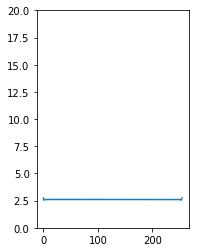

In [51]:
from scipy.stats import truncnorm

factor = 256
nx = list(range(factor-1))
ny = []

for i in nx:
    u1, v1 = truncnorm.stats(
                 norm.ppf(max(0.5/factor, i/factor)),
                 norm.ppf((i+1)/factor),
                 moments='mv')
    
    u2, v2 = truncnorm.stats(
                 norm.ppf((i+1)/factor),
                 norm.ppf(min((factor-0.5)/factor, (i+2)/factor)),
                 moments='mv')
    
    d = abs(u1 - u2) / ((16 * v1 * v2) ** (1/4))
    dd = numpy.sqrt(d*d - 1)
    t = 2 * numpy.log(d - dd) + 2 * d * dd
    ny.append(t)

ax = matplotlib.pyplot.subplot(1, 2, 1)
ax.set_ylim(0, 20)
matplotlib.pyplot.plot(nx, ny)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


(array([  73.,  533.,  389.,   57.,  114.,  273.,  319.,  210.,   67.,   13.]),
 array([ 0.00038404,  0.00071873,  0.00105342,  0.0013881 ,  0.00172279,
         0.00205747,  0.00239216,  0.00272685,  0.00306153,  0.00339622,
         0.00373091]),
 <a list of 10 Patch objects>)

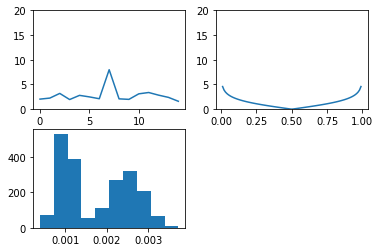

In [75]:
%matplotlib inline
import numpy

rand = numpy.random.RandomState(seed=1234567)

size = 1024
factor = 128
xval = sorted(
    list(rand.normal(1e-3, 2e-4, size))
  + list(rand.normal(2.5e-3, 4e-4, size)))

ty = []
tx = range(int(len(xval)/factor) - 1)
for i in tx:
    r1 = xval[i*factor : (i+1)*factor]
    r2 = xval[(i+1)*factor : (i+2)*factor]

    u1 = numpy.mean(r1)
    u2 = numpy.mean(r2)
    o1 = numpy.std(r1)
    o2 = numpy.std(r2)

    d = abs(u1 - u2) / (numpy.sqrt(4 * o1 * o2))
    dd = numpy.sqrt(d*d - 1)
    t = 2 * numpy.log(d - dd) + 2 * d * dd
    ty.append(t)

ly = []
lx = numpy.linspace(0.0, 1.0, 100)
for p in lx:
    l = numpy.log(1 - p) - numpy.log(p)
    ly.append(numpy.abs(l))
    
ax = matplotlib.pyplot.subplot(2, 2, 1)
ax.set_ylim(0, 20)
matplotlib.pyplot.plot(tx, ty)

ax = matplotlib.pyplot.subplot(2, 2, 2)
ax.set_ylim(0, 20)
matplotlib.pyplot.plot(lx, ly)

ax = matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.hist(xval)

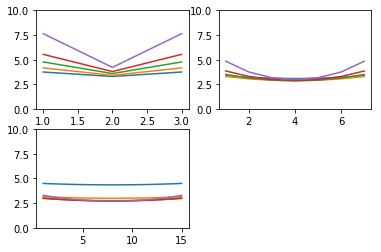

In [120]:
def simulate_norm(depth):
    for width in [32, 64, 128, 256, 1024]:
        factor = width // depth
        xval = norm.cdf(
            numpy.linspace(
                norm.ppf(1/width),
                norm.ppf(1 - 1/width),
                width))
        
        ty = []
        tx = range(depth - 1)
        for i in tx:
            r1 = xval[i*factor : (i+1)*factor]
            r2 = xval[(i+1)*factor : (i+2)*factor]

            u1 = numpy.mean(r1)
            u2 = numpy.mean(r2)
            o1 = numpy.std(r1)
            o2 = numpy.std(r2)

            d = abs(u1 - u2) / (numpy.sqrt(4 * o1 * o2))
            dd = numpy.sqrt(d*d - 1)
            t = 2 * numpy.log(d - dd) + 2 * d * dd
            ty.append(t)

        matplotlib.pyplot.plot([x+1 for x in tx], ty)

ax = matplotlib.pyplot.subplot(2, 2, 1)
ax.set_ylim(0, 10)
simulate_norm(4)
ax = matplotlib.pyplot.subplot(2, 2, 2)
ax.set_ylim(0, 10)
simulate_norm(8)
ax = matplotlib.pyplot.subplot(2, 2, 3)
ax.set_ylim(0, 10)
simulate_norm(16)

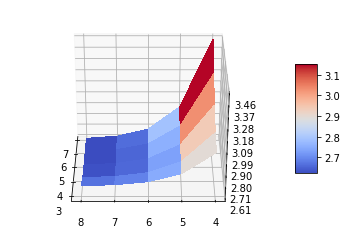

In [64]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy
from scipy.stats import norm

fig = plt.figure()
ax = fig.gca(projection='3d')

slice_n = 0
Xarray = numpy.arange(3.0, 8.0, 1.0) # 2.0 is OK
Yarray = numpy.arange(4.0, 9.0, 1.0) # 4.0 is OK
X, Y = numpy.meshgrid(Xarray, Yarray)
Z = X + 0.0
W = X + 0.0

for i,num_slices_pow in enumerate(list(Yarray)):
    depth = 2 ** int(num_slices_pow)

    for j,slice_width_pow in enumerate(list(Xarray)):
        factor = 2 ** int(slice_width_pow)
        width = depth * factor
        W[i][j] = width

        xval = norm.cdf(
            numpy.linspace(
                norm.ppf(1/width),
                norm.ppf(1 - 1/width),
                width))

        r1 = xval[slice_n*factor : (slice_n+1)*factor]
        r2 = xval[(slice_n+1)*factor : (slice_n+2)*factor]

        u1 = numpy.mean(r1)
        u2 = numpy.mean(r2)
        o1 = numpy.std(r1)
        o2 = numpy.std(r2)

        d = abs(u1 - u2) / numpy.sqrt(4 * o1 * o2)
        dd = numpy.sqrt(d*d - 1)
        t = 2 * numpy.log(d - dd) + 2 * d * dd
        
        Z[i][j] = t

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(30, 180)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [11]:
class HistogramSlice(object):
    test_threshold = 16
    test_half_threshold = 8
    
    def __init__(self, count=0, full_sum=0.0, squared_sum=0.0):
        self.count = count
        self.sum = full_sum
        self.is_bimodal = False
        
        half_count = count // 2
        divisor = half_count / count
        half_sum = full_sum * divisor
        half_squared_sum = squared_sum * divisor
        
        self.left_count = half_count
        self.left_sum = half_sum
        self.left_squaredsum = half_squared_sum
        
        self.right_count = half_count
        self.right_sum = half_sum
        self.right_squaredsum = half_squared_sum
        
    def insert(self, val):
        assert self.is_bimodal is False
        
        self.count += 1
        self.sum += val
        mean = self.sum / self.count

        if val < mean:
            self.left_count += 1
            self.left_sum += val
            self.left_squaredsum += val*val
        else:
            self.right_count += 1
            self.right_sum += val
            self.right_squaredsum += val*val
            
        # TODO:
        #    add count-min-sketch for median?
        
    @property
    def is_bimodal(self):
        if self.is_bimodal:
            return True
        
        if ((self.count < self.test_threshold)
                or (self.test_left_count < self.test_half_threshold)
                or (self.test_right_count < self.test_half_threshold)):
            return False
        
        # TODO: all this jazz can be algebraically optimized
        u1 = self.left_sum / self.left_count 
        u2 = self.right_sum / self.right_count 
        v1 = (self.left_squaredsum - u1 * self.left_sum) / (self.left_count - 1)
        v2 = (self.right_squaredsum - u2 * self.right_sum) / (self.right_count - 1)

        d = 0.5 * abs(u1 - u2) / ((v1 * v2) ** 0.25)
        dd = numpy.sqrt(d*d - 1)
        t = 2 * numpy.log(d - dd) + 2 * d * dd
        
        # correct t for standard normal of slice
        # compare against threshold
        
        self.is_bimodal = ...
        return self.is_bimodal
    
    def split(self):
        return (Slice(self.left_count, self.left_sum, self.left_squaredsum),
                Slice(self.right_count, self.right_sum, self.right_squaredsum))

class HistogramTree(object):
    def __init__(self):
        pass
        
    def insert_point(self, val):
        pass
    
        # 1.) find non-bimodal slice
        # 2.) insert into it
        # 3.) check it for bimodality
        # 4.) split if necessary
        # 5.) get bin in slice
        # 6.) add to bin, checking for anomaly
    


SyntaxError: invalid syntax (<ipython-input-11-d862d2fd1795>, line 61)

In [100]:
%matplotlib inline
import numpy

rand = numpy.random.RandomState(seed=1234567)

size = 1024
factor = 128
xval = sorted(
    list(rand.normal(1e-3, 2e-4, size))
  + list(rand.normal(2.5e-3, 4e-4, size)))

ty = []
tx = range(int(len(xval)/factor) - 1)
for i in tx:
    r1 = xval[i*factor : (i+1)*factor]
    r2 = xval[(i+1)*factor : (i+2)*factor]

    u1 = numpy.mean(r1)
    u2 = numpy.mean(r2)
    o1 = numpy.std(r1)
    o2 = numpy.std(r2)

    d = abs(u1 - u2) / (numpy.sqrt(4 * o1 * o2))
    dd = numpy.sqrt(d*d - 1)
    t = 2 * numpy.log(d - dd) + 2 * d * dd
    ty.append(t)

ly = []
lx = numpy.linspace(0.0, 1.0, 100)
for p in lx:
    l = numpy.log(1 - p) - numpy.log(p)
    ly.append(numpy.abs(l))
    
ax = matplotlib.pyplot.subplot(2, 2, 1)
ax.set_ylim(0, 20)
matplotlib.pyplot.plot(tx, ty)

ax = matplotlib.pyplot.subplot(2, 2, 2)
ax.set_ylim(0, 20)
matplotlib.pyplot.plot(lx, ly)

ax = matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.hist(xval)

nan

%matplotlib inline
import numpy
import numpy.random

rand = numpy.random.RandomState(seed=1234567)

size = 1024
factor = 128
xval = numpy.random.shuffle(
           numpy.concatenate((
               rand.normal(1e-3, 2e-4, size),
               rand.normal(2.5e-3, 4e-4, size)
           )))
           